![](attachment:image.png)

![](attachment:image.png)

## LDA的使用, 分析yelp数据集

有个常用的LDA工具：

- [Gensim](https://radimrehurek.com/gensim/models/ldamodel.html)
- [Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)


In [1]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

yelp = pd.read_csv('./datasets/yelp.csv', encoding='utf-8')
print (yelp['text'].head())

# 把每个文本表示成count vector. 
vectorizer = CountVectorizer(stop_words="english")
X = vectorizer.fit_transform(yelp['text'])

0    My wife took me here on my birthday for breakf...
1    I have no idea why some people give bad review...
2    love the gyro plate. Rice is so good and I als...
3    Rosie, Dakota, and I LOVE Chaparral Dog Park!!...
4    General Manager Scott Petello is a good egg!!!...
Name: text, dtype: object


In [2]:
lda   = LatentDirichletAllocation(n_topics=2, learning_method="batch", random_state=42)
model = lda.fit(X)

TypeError: __init__() got an unexpected keyword argument 'n_topics'

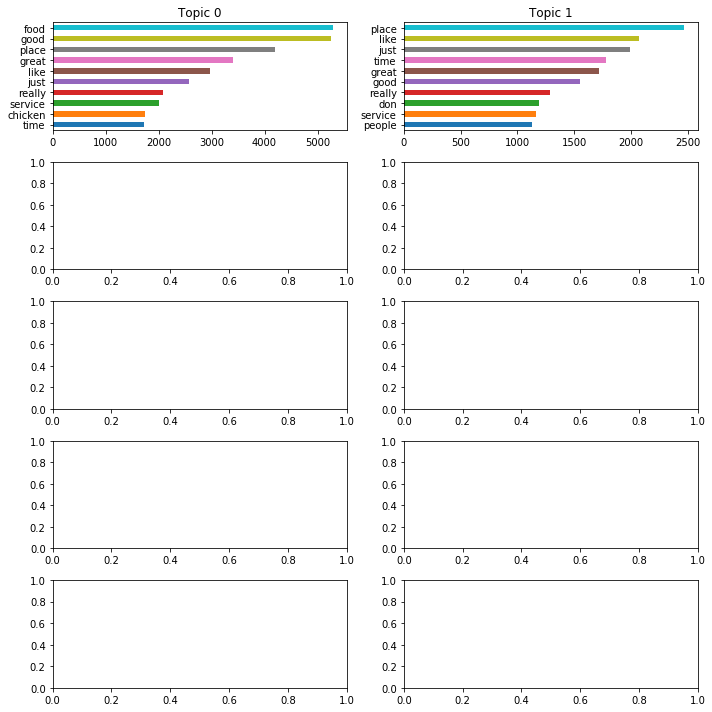

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

####
# Per topic: (token, pseudocount)
# pseudocount represents the number of times word j was assigned to topic i
# 
# We can to convert these to a normalized form -- well you don't have to
# but it's easier to understand the output in this form.  Also, this is 
# consistent with how Gensim performs.  After some consideration, we will plot these out.
####

def display_topics(model, feature_names, no_words = 10, plot = False, plot_dim=(5,2)):
    
    topics_tokens = []
    
    for topic_idx, topic in enumerate(model.components_):

        topic = zip(feature_names, topic)
        topic = sorted(topic, key=lambda pair: pair[1])
        
        topic_words = [(token, counts)
                       for token, counts in topic[:-no_words - 1:-1]]
        
        topics_tokens.append(topic_words)
        
        if not plot:
            print ("Topic %d:" % (topic_idx))
            print (topic_words)
        
    if plot:
        
        plot_matrix = np.arange(10).reshape(5,2)
    
        fig, ax = plt.subplots(figsize=(10, 10), nrows=5, ncols=2)
        
        topics = [
            {key: value for key, value in topic} 
                  for topic in topics_tokens
        ]
        
        row = 0
        
        for topic_id, topic in enumerate(topics):
            
            column = (0 if topic_id % 2 == 0 else 1)
                
            chart = pd.DataFrame([topic]).iloc[0].sort_values(axis=0)
            chart.plot(kind="barh", title="Topic %d" % topic_id, ax=ax[row, column])
                
            row += 1 if column == 1 else 0
        
        plt.tight_layout()
            

display_topics(model, vectorizer.get_feature_names(), no_words=10, plot=True)

In [18]:
display_topics(model, vectorizer.get_feature_names(), no_words=10)

Topic 0:
[('good', 2302.6328623543204), ('food', 1712.7564008897298), ('chicken', 1377.8106126729263), ('great', 1369.724410747316), ('place', 1259.102358326213), ('like', 1170.8289088208714), ('cheese', 1090.0246938619125), ('sauce', 998.424592379383), ('really', 951.8673513178557), ('just', 874.4452310561048)]
Topic 1:
[('pizza', 1326.7330216938742), ('good', 316.4043853024131), ('place', 236.635740816335), ('time', 228.44088800713953), ('like', 223.70648865211587), ('just', 214.21268586798757), ('don', 212.17702585306915), ('crust', 202.39068704183634), ('really', 198.69027650233025), ('little', 191.18086417469127)]
Topic 2:
[('burger', 832.1152628718013), ('fries', 689.3605867715271), ('food', 343.2195855384175), ('like', 325.59575902783104), ('good', 285.69358467377253), ('place', 272.7751827702345), ('burgers', 248.60281235086552), ('lunch', 164.92598785020664), ('great', 164.5500089768819), ('order', 148.05743924768694)]
Topic 3:
[('food', 2361.069909887321), ('place', 1646.1941

In [19]:
comp = model.transform(X)
document_topics = pd.DataFrame(comp, columns=["topic %d" % i for i in range(comp.shape[1])])
top_topics = document_topics['topic 0'] > .8
document_topics[top_topics].head()

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
10,0.911565,0.003572,0.003572,0.003572,0.003572,0.059860,0.003572,0.003572,0.003572,0.003572
18,0.918468,0.001163,0.001163,0.072228,0.001163,0.001163,0.001163,0.001163,0.001163,0.001163
20,0.829591,0.001961,0.154719,0.001961,0.001961,0.001961,0.001961,0.001961,0.001961,0.001961
42,0.924983,0.008335,0.008335,0.008336,0.008336,0.008334,0.008336,0.008334,0.008335,0.008336
75,0.845220,0.003704,0.003704,0.125144,0.003704,0.003705,0.003705,0.003705,0.003704,0.003705


### Gibbs sampler for LDA

In [29]:
# words
W = np.array([0, 1, 2, 3, 4])

# D := document words
X = np.array([
    [0, 0, 1, 2, 2],
    [0, 0, 1, 1, 1],
    [0, 1, 2, 2, 2],
    [4, 4, 4, 4, 4],
    [3, 3, 4, 4, 4],
    [3, 4, 4, 4, 4]
])

N_D = X.shape[0]  # num of docs
N_V = W.shape[0]  # num of words
N_K = 2  # num of topics

In [30]:
# Dirichlet priors
alpha = 1
gamma = 1

# Z := word topic assignment
Z = np.zeros(shape=[N_D, N_V])

for i in range(N_D):
    for l in range(N_V):
        Z[i, l] = np.random.randint(N_K)  # randomly assign word's topic

# Pi := document topic distribution
theta = np.zeros([N_D, N_K])

for i in range(N_D):
    theta[i] = np.random.dirichlet(alpha*np.ones(N_K))

# phi := word topic distribution
phi = np.zeros([N_K, N_V])

for k in range(N_K):
    phi[k] = np.randomt.dirichlet(gamma*np.ones(N_V))

for it in range(1000):
    # Sample from full conditional of Z
    # ---------------------------------
    for i in range(N_D):
        for v in range(N_V):
            # Calculate params for Z
            p_iv = np.exp(np.log(theta[i]) + np.log(phi[:, X[i, v]]))
            p_iv /= np.sum(p_iv)

            # Resample word topic assignment Z
            Z[i, v] = np.random.multinomial(1, p_iv).argmax()

    # Sample from full conditional of Pi
    # ----------------------------------
    for i in range(N_D):
        m = np.zeros(N_K)

        # Gather sufficient statistics
        for k in range(N_K):
            m[k] = np.sum(Z[i] == k)

        # Resample doc topic dist.
        theta[i, :] = np.random.dirichlet(alpha + m)

    # Sample from full conditional of B
    # ---------------------------------
    for k in range(N_K):
        n = np.zeros(N_V)

        # Gather sufficient statistics
        for v in range(N_V):
            for i in range(N_D):
                for l in range(N_V):
                    n[v] += (X[i, l] == v) and (Z[i, l] == k)

        # Resample word topic dist.
        phi[k, :] = np.random.dirichlet(gamma + n)

In [31]:
print (theta)

[[0.8909328  0.1090672 ]
 [0.43150659 0.56849341]
 [0.90872547 0.09127453]
 [0.00554831 0.99445169]
 [0.55382813 0.44617187]
 [0.28755563 0.71244437]]
